In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
import os
os.environ['REQUESTS_CA_BUNDLE'] = ''

In [4]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ['Blepharitis','Conjunctivitis','Entropion','EyelidTumor','HealthyEye','Mastopathy','Nuclear Sclerosis','Pigmented Keratitis']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output 

In [5]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 8]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [6]:
# Setup directory paths to train and test images
train_dir = '/Users/sandundesilva/Downloads/Datasets/train'
test_dir = '/Users/sandundesilva/Downloads/Datasets/test'

In [7]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [8]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [9]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)


In [11]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1357 | train_acc: 0.5661 | test_loss: 1.0445 | test_acc: 0.6020
Epoch: 2 | train_loss: 0.8778 | train_acc: 0.6633 | test_loss: 0.9694 | test_acc: 0.6285
Epoch: 3 | train_loss: 0.7892 | train_acc: 0.6953 | test_loss: 0.9372 | test_acc: 0.6451
Epoch: 4 | train_loss: 0.7360 | train_acc: 0.7140 | test_loss: 0.9157 | test_acc: 0.6645
Epoch: 5 | train_loss: 0.6948 | train_acc: 0.7337 | test_loss: 0.9026 | test_acc: 0.6564
Epoch: 6 | train_loss: 0.6635 | train_acc: 0.7435 | test_loss: 0.8971 | test_acc: 0.6603
Epoch: 7 | train_loss: 0.6386 | train_acc: 0.7551 | test_loss: 0.9051 | test_acc: 0.6381
Epoch: 8 | train_loss: 0.6172 | train_acc: 0.7600 | test_loss: 0.8835 | test_acc: 0.6728
Epoch: 9 | train_loss: 0.5990 | train_acc: 0.7708 | test_loss: 0.9091 | test_acc: 0.6497
Epoch: 10 | train_loss: 0.5824 | train_acc: 0.7755 | test_loss: 0.9081 | test_acc: 0.6360


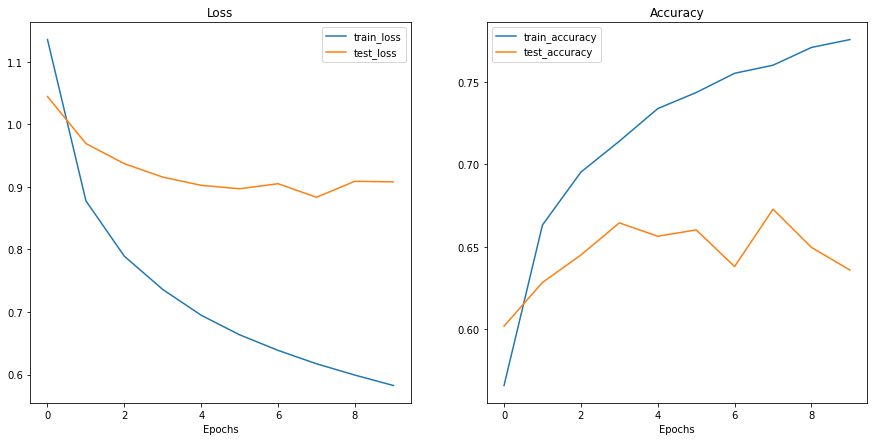

In [12]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results) 

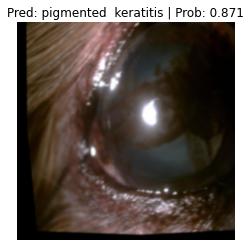

In [30]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/Users/sandundesilva/Downloads/Datasets/train/pigmented  keratitis/D0_31d86e47-60a5-11ec-8402-0a7404972c70_jpg.rf.55fa8bf3c9915fb046ae440e9bb54249.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

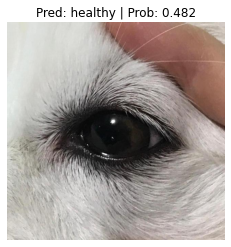

In [16]:
# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/Users/sandundesilva/Documents/4th year/machine vision/CW/healthy2.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [21]:
# Define the file path where you want to save the model
model_save_path = "pretrained_vit_model.pth"

# Save the entire model
torch.save(pretrained_vit, model_save_path)

# if you only want to save the model's state dictionary (parameters)
# torch.save(pretrained_vit.state_dict(), model_save_path)
